# Portfolio Construction

In [1]:
import os
import joblib
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
import cvxpy as cp
from sklearn.covariance import LedoitWolf

from Alpha_Research import Alpha_Research

In [28]:
data_folder = "data"
model_folder = "model"

is_name = os.path.join(data_folder, "df_is.h5")
df_is = pd.read_hdf(is_name)
os_name = os.path.join(data_folder, "df_os.h5")
df_os = pd.read_hdf(os_name)

model_name = os.path.join(model_folder, "cat_exponential.json")
model = CatBoostClassifier()
model.load_model(model_name)

In [29]:
def q_restoring(q_label, target):
    qs = [target.quantile(i/5) for i in range(1, 6)]
    
    medians = [] # quantile is highly skewed
    for i in range(5):
        if i == 0:
            medians.append(target[(target<qs[i])].median())
        elif i < 4:
            medians.append(target[(target>=qs[i])&(target>qs[i])].median())
        else:
            medians.append(target[(target>=qs[i])].median())

    def restoring(x):
        return medians[int(x)-1]
    return q_label.apply(restoring)

    return medians

In [30]:
df_is_dts = df_is.reset_index()['Date']
df_is_dt = df_is_dts[~df_is_dts.duplicated()].to_list()
df_os_dts = df_os.reset_index()['Date']
df_os_dt = df_os_dts[~df_os_dts.duplicated()].to_list()

In [31]:
df_isos = pd.concat([df_is, df_os], axis=0, join='inner')
df_isos_dts = df_isos.reset_index()['Date']
df_isos_dt = df_isos_dts[~df_isos_dts.duplicated()].to_list()

In [32]:
ar = Alpha_Research()

In [33]:
def ledoit_wolf_cov(price_data, universe, scaling=252/12):
    df_ret = (1+price_data.pct_change()).apply(np.log).iloc[1:]
    df_ret = df_ret.T.fillna(df_ret.mean(axis=1)).T
    cov = LedoitWolf().fit(df_ret)
    df_cov = pd.DataFrame(cov.covariance_*np.sqrt(scaling),
                      index=universe, columns=universe)
    return df_cov

# Out-Of-Sample Only

In [34]:
# portfolio optimization
portfolio_opt_results = dict()

# change for different tests
dataset = df_os.copy()
time_index = df_os_dt.copy()

for dt in tqdm(time_index):
    # expexted return
    temp_sectors = ar.sector_dict[dt]
    X = dataset[dataset.index.get_level_values(0)==dt].iloc[:,:-1]
    universe = X.index.get_level_values(1)
    temp_index_weight = pd.Series(ar.data_weight[dt])[universe]
    y_q = pd.Series(model.predict(X).reshape(len(X)))
    y = q_restoring(y_q, df_is['target']).to_numpy()

    # boolean mask for sector
    w_s = []
    for sc in temp_sectors.keys():
        w_s.append(temp_index_weight.index.isin(temp_sectors[sc]))
        
    # covariance estimation with Ledoit-Wolf Shirnkage
    idx = ar.d['ADJC'].index.to_list().index(dt)
    df_p = ar.d['ADJC'][universe].iloc[idx-252*3:idx+1]
    df_cov = ledoit_wolf_cov(df_p, universe)

    # long-short mean variance optimization
    # define variables
    w = cp.Variable(len(universe))
    var = cp.quad_form(w, df_cov.to_numpy())
    e_r = y @ w

    ub = cp.Parameter(nonneg=True, name='ub')
    lb = cp.Parameter(nonneg=True, name='lb')
    net = cp.Parameter(nonneg=True, name='net')
    gross = cp.Parameter(nonneg=True, name='gross')
    target = cp.Parameter(nonneg=True, name='target')
    sc_net = cp.Parameter(nonneg=True, name='sc_net')
    sc_gross = cp.Parameter(nonneg=True, name='sc_gross')
    
    # only for MTO
    lb2 = temp_index_weight.to_numpy()

    # define objective, constraints and problem
    objective = cp.Maximize(e_r)
    constraints = [var <= target,
                   cp.sum(w) == net,
                   cp.sum(cp.abs(w)) <= gross,
                   w >= -lb,
                   w <= ub,
                   w >= -lb2]
    
    for i in range(len(w_s)):
        constraints.append(cp.sum(w @ w_s[i]) == sc_net)
        constraints.append(cp.sum(cp.abs(w @ w_s[i])) <= sc_gross)
        

        
    problem = cp.Problem(objective, constraints)

    # assign value to parameters
    target.value = 0.20
    net.value = 0.0
    gross.value = 2.0
    ub.value = 0.10 * gross.value
    lb.value = 0.10 * gross.value
    sc_net.value = 0.00 * gross.value
    sc_gross.value = 0.15 * gross.value
    
    # solve
    problem.solve()
    portfolio_opt_results[dt] = {'E_r':e_r.value,
                                 'var':var.value,
                                 'w':w.value,
                                 'universe':universe,
                                 'index':lb2}

100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:40<00:00,  1.38it/s]


In [35]:
bt_dict = dict()
for dt in tqdm(time_index):
    temp_opt = portfolio_opt_results[dt]
    temp_universe = temp_opt['universe']
    temp_target = ar.df_target.loc[dt][temp_universe]
    ls_w = temp_opt['w']
    lo_w = temp_opt['w'] + temp_opt['index']
    bt_dict[dt] = {'Long-Short':(ls_w * temp_target).sum(),
                   'Long-Only':(lo_w * temp_target).sum()}

100%|████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 1145.93it/s]


In [36]:
bt_ret = pd.DataFrame(bt_dict).T
benchmark = ar.data_index['KS200']
# shift 1 month
start = bt_ret.index[1]
end = benchmark[benchmark.index>bt_ret.index[-1]].index[0]
new_index = benchmark[(benchmark.index>=start)&(benchmark.index<=end)].index
bt_ret.set_index(new_index, inplace=True)
bt_ret['KS200'] = benchmark / 100
bt_cum = (1+bt_ret).cumprod()

In [37]:
portfolio_path = "portfolio"
portfolios = [bt_ret, bt_cum]
joblib.dump(portfolios, os.path.join(portfolio_path, 'portfolio.sav'), compress=1)

['portfolio\\portfolio.sav']

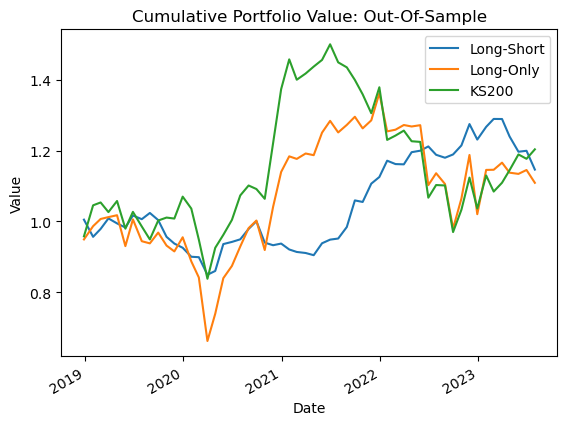

In [38]:
plot_name = os.path.join(portfolio_path, 'Portfolio_Value_OS.png')
fig1, ax1 = plt.subplots()
bt_cum.plot(ax=ax1)
ax1.set_title("Cumulative Portfolio Value: Out-Of-Sample")
ax1.set_xlabel("Date")
ax1.set_ylabel("Value")
ax1.legend()
fig1.figure.savefig(plot_name, bbox_inches='tight', dpi=300)

In [39]:
bt_cum.iloc[-1]

Long-Short    1.146372
Long-Only     1.109070
KS200         1.203457
Name: 2023-07-31 00:00:00, dtype: float64

### Full-Period

In [21]:
# portfolio optimization
portfolio_opt_results = dict()

# change for different tests
dataset = df_isos.copy()
time_index = df_isos_dt.copy()

for dt in tqdm(time_index):
    # expexted return
    temp_sectors = ar.sector_dict[dt]
    X = dataset[dataset.index.get_level_values(0)==dt].iloc[:,:-1]
    universe = X.index.get_level_values(1)
    temp_index_weight = pd.Series(ar.data_weight[dt])[universe]
    y_q = pd.Series(model.predict(X).reshape(len(X)))
    y = q_restoring(y_q, df_is['target']).to_numpy()

    # boolean mask for sector
    w_s = []
    for sc in temp_sectors.keys():
        w_s.append(temp_index_weight.index.isin(temp_sectors[sc]))
        
    # covariance estimation with Ledoit-Wolf Shirnkage
    idx = ar.d['ADJC'].index.to_list().index(dt)
    df_p = ar.d['ADJC'][universe].iloc[idx-252*3:idx+1]
    df_cov = ledoit_wolf_cov(df_p, universe)

    # long-short mean variance optimization
    # define variables
    w = cp.Variable(len(universe))
    var = cp.quad_form(w, df_cov.to_numpy())
    e_r = y @ w

    ub = cp.Parameter(nonneg=True, name='ub')
    lb = cp.Parameter(nonneg=True, name='lb')
    net = cp.Parameter(nonneg=True, name='net')
    gross = cp.Parameter(nonneg=True, name='gross')
    target = cp.Parameter(nonneg=True, name='target')
    sc_net = cp.Parameter(nonneg=True, name='sc_net')
    sc_gross = cp.Parameter(nonneg=True, name='sc_gross')
    
    # only for MTO
    lb2 = temp_index_weight.to_numpy()

    # define objective, constraints and problem
    objective = cp.Maximize(e_r)
    constraints = [var <= target,
                   cp.sum(w) == net,
                   cp.sum(cp.abs(w)) <= gross,
                   w >= -lb,
                   w <= ub,
                   w >= -lb2]
    
    for i in range(len(w_s)):
        constraints.append(cp.sum(w @ w_s[i]) == sc_net)
        constraints.append(cp.sum(cp.abs(w @ w_s[i])) <= sc_gross)
        

        
    problem = cp.Problem(objective, constraints)

    # assign value to parameters
    target.value = 0.20
    net.value = 0.0
    gross.value = 2.0
    ub.value = 0.10 * gross.value
    lb.value = 0.10 * gross.value
    sc_net.value = 0.00 * gross.value
    sc_gross.value = 0.15 * gross.value
    
    # solve
    problem.solve()
    portfolio_opt_results[dt] = {'E_r':e_r.value,
                                 'var':var.value,
                                 'w':w.value,
                                 'universe':universe,
                                 'index':lb2}

100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [01:15<00:00,  2.02it/s]


In [22]:
bt_dict = dict()
for dt in tqdm(time_index):
    temp_opt = portfolio_opt_results[dt]
    temp_universe = temp_opt['universe']
    temp_target = ar.df_target.loc[dt][temp_universe]
    ls_w = temp_opt['w']
    lo_w = temp_opt['w'] + temp_opt['index']
    bt_dict[dt] = {'Long-Short':(ls_w * temp_target).sum(),
                   'Long-Only':(lo_w * temp_target).sum()}

100%|██████████████████████████████████████████████████████████████████████████████| 153/153 [00:00<00:00, 1703.92it/s]


In [23]:
bt_ret = pd.DataFrame(bt_dict).T
benchmark = ar.data_index['KS200']
# shift 1 month
start = bt_ret.index[1]
end = benchmark[benchmark.index>bt_ret.index[-1]].index[0]
new_index = benchmark[(benchmark.index>=start)&(benchmark.index<=end)].index
bt_ret.set_index(new_index, inplace=True)
bt_ret['KS200'] = benchmark / 100
bt_cum = (1+bt_ret).cumprod()

In [24]:
portfolio_path = "portfolio"
portfolios = [bt_ret, bt_cum]
joblib.dump(portfolios, os.path.join(portfolio_path, 'portfolio.sav'), compress=1)

['portfolio\\portfolio.sav']

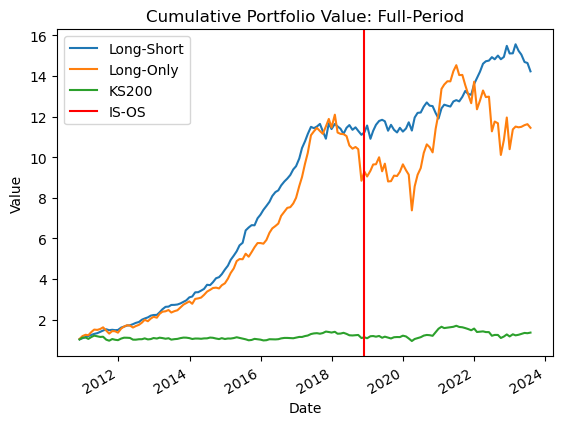

In [31]:
plot_name = os.path.join(portfolio_path, 'Portfolio_Value_IS.png')
fig2, ax2 = plt.subplots()
bt_cum.plot(ax=ax2)
ax2.axvline(x=df_os.index.get_level_values(0)[0],
            c='r', label='IS-OS')
ax2.set_title("Cumulative Portfolio Value: Full-Period")
ax2.set_xlabel("Date")
ax2.set_ylabel("Value")
ax2.legend()
fig2.figure.savefig(plot_name, bbox_inches='tight', dpi=300)

In [26]:
bt_cum.iloc[-1]

Long-Short    14.230087
Long-Only     11.449392
KS200          1.365058
Name: 2023-07-31 00:00:00, dtype: float64

## Non-Restricted Long-Short

In [39]:
# portfolio optimization
portfolio_opt_results = dict()

# change for different tests
dataset = df_os.copy()
time_index = df_os_dt.copy()

for dt in tqdm(time_index):
    # expexted return
    temp_sectors = ar.sector_dict[dt]
    X = dataset[dataset.index.get_level_values(0)==dt].iloc[:,:-1]
    universe = X.index.get_level_values(1)
    temp_index_weight = pd.Series(ar.data_weight[dt])[universe]
    y_q = pd.Series(model.predict(X).reshape(len(X)))
    y = q_restoring(y_q, df_is['target']).to_numpy()

    # boolean mask for sector
    w_s = []
    for sc in temp_sectors.keys():
        w_s.append(temp_index_weight.index.isin(temp_sectors[sc]))
        
    # covariance estimation with Ledoit-Wolf Shirnkage
    idx = ar.d['ADJC'].index.to_list().index(dt)
    df_p = ar.d['ADJC'][universe].iloc[idx-252*3:idx+1]
    df_cov = ledoit_wolf_cov(df_p, universe)

    # long-short mean variance optimization
    # define variables
    w = cp.Variable(len(universe))
    var = cp.quad_form(w, df_cov.to_numpy())
    e_r = y @ w

    ub = cp.Parameter(nonneg=True, name='ub')
    lb = cp.Parameter(nonneg=True, name='lb')
    net = cp.Parameter(nonneg=True, name='net')
    gross = cp.Parameter(nonneg=True, name='gross')
    target = cp.Parameter(nonneg=True, name='target')
    sc_net = cp.Parameter(nonneg=True, name='sc_net')
    sc_gross = cp.Parameter(nonneg=True, name='sc_gross')

    # define objective, constraints and problem
    objective = cp.Maximize(e_r)
    constraints = [var <= target,
                   cp.sum(w) == net,
                   cp.sum(cp.abs(w)) <= gross,
                   w >= -lb,
                   w <= ub]
    
    for i in range(len(w_s)):
        constraints.append(cp.sum(w @ w_s[i]) == sc_net)
        constraints.append(cp.sum(cp.abs(w @ w_s[i])) <= sc_gross)
        

        
    problem = cp.Problem(objective, constraints)

    # assign value to parameters
    target.value = 0.40
    net.value = 0.0
    gross.value = 2.0
    ub.value = 0.20 * gross.value
    lb.value = 0.20 * gross.value
    sc_net.value = 0.00 * gross.value
    sc_gross.value = 0.40 * gross.value
    
    # solve
    problem.solve()
    portfolio_opt_results[dt] = {'E_r':e_r.value,
                                 'var':var.value,
                                 'w':w.value,
                                 'universe':universe,
                                 'index':lb2}

100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:29<00:00,  1.90it/s]


In [41]:
bt_dict = dict()
for dt in tqdm(time_index):
    temp_opt = portfolio_opt_results[dt]
    temp_universe = temp_opt['universe']
    temp_target = ar.df_target.loc[dt][temp_universe]
    ls_w = temp_opt['w']
    bt_dict[dt] = {'Long-Short':(ls_w * temp_target).sum()}

100%|████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 1604.29it/s]


In [42]:
bt_ret = pd.DataFrame(bt_dict).T
benchmark = ar.data_index['KS200']
# shift 1 month
start = bt_ret.index[1]
end = benchmark[benchmark.index>bt_ret.index[-1]].index[0]
new_index = benchmark[(benchmark.index>=start)&(benchmark.index<=end)].index
bt_ret.set_index(new_index, inplace=True)
bt_ret['KS200'] = benchmark / 100
bt_cum = (1+bt_ret).cumprod()

In [43]:
portfolio_path = "portfolio"
portfolios = [bt_ret, bt_cum]
joblib.dump(portfolios, os.path.join(portfolio_path, 'portfolio.sav'), compress=1)

['portfolio\\portfolio.sav']

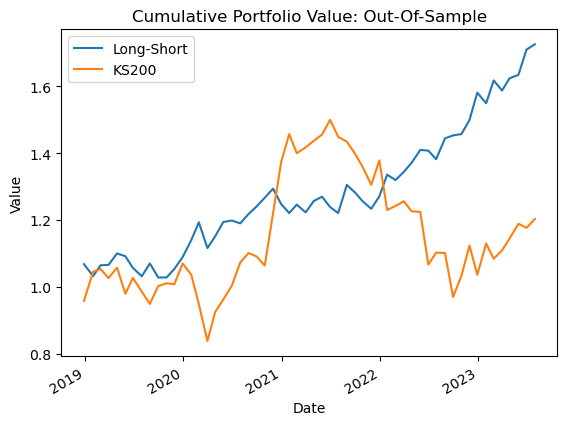

In [44]:
plot_name = os.path.join(portfolio_path, 'Portfolio_Value_LS_OS.png')
fig1, ax1 = plt.subplots()
bt_cum.plot(ax=ax1)
ax1.set_title("Cumulative Portfolio Value: Out-Of-Sample")
ax1.set_xlabel("Date")
ax1.set_ylabel("Value")
ax1.legend()
fig1.figure.savefig(plot_name, bbox_inches='tight', dpi=300)

In [37]:
bt_cum.iloc[-1]

Long-Short    1.267355
Long-Only     1.231792
KS200         1.203457
Name: 2023-07-31 00:00:00, dtype: float64